In [1]:
# I.
# -*- coding: utf-8 -*-

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import colorbar, colors

import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import os
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



In [2]:
# II.

# Extracting the data from Cartopy

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
country = next(countries)

data = lambda country: (country.attributes['REGION_WB'], country.attributes['NAME_EN'], 
                        country.attributes['NAME_ES'], country.attributes['POP_EST'], country.attributes['CONTINENT']) 

countries_pop = sorted(countries, key=data)

# Obtengo población total mundial
popt=0
ptot= [popt + co.attributes['POP_EST'] for co in countries_pop]
pop_total = float(sum(ptot))

# Addind the needed data to a list ...
region_wb = [] 
continent = []
pop_est = [] 
name_en =[]
name_es =[]
percent_pays = []

for country in countries_pop:
    region_wb.append(country.attributes['REGION_WB'])
    continent.append(country.attributes['CONTINENT'])
    name_en.append(country.attributes['NAME_EN'])
    name_es.append(country.attributes['NAME_ES'])
    pop_est.append(country.attributes['POP_EST'])
    percent_pays.append(float(country.attributes['POP_EST'])/float(pop_total))
    

percent_qpays = []
for n in percent_pays:
    percent_qpays.append(str(n))
    
# To convert it to a Dataframe:
shpfilename_df = pd.DataFrame(np.column_stack([region_wb, continent, name_en, name_es, pop_est, percent_pays, percent_qpays]), 
                               columns=['region_wb', 'continent', 'name_en', 'name_es', 'pop_est', 'percent_pays', 'percent_qpays'])

# And changing the data to a numeric values in the Dataframe
shpfilename_df = shpfilename_df.copy()
s1 = shpfilename_df.loc[:,'percent_pays']
s2 = shpfilename_df.loc[:,'pop_est']
shpfilename_df['percent_pays'] = pd.to_numeric(s1, errors='coerce', downcast = 'float')
shpfilename_df['percent_pays%'] = shpfilename_df['percent_pays']*100
shpfilename_df['pop_est'] = pd.to_numeric(s2, errors='coerce', downcast = 'float')


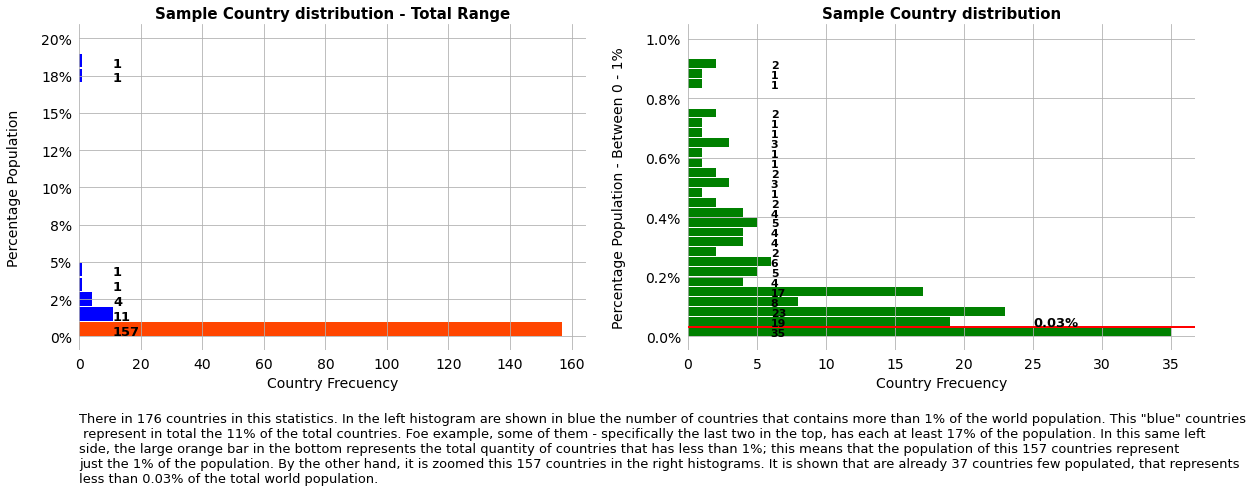

In [15]:
# III - Histogram division

fig = plt.figure(figsize=(15,15))

# Setting the axes
plt.rcParams['axes.spines.bottom'] =False
plt.rcParams['axes.spines.left'] =False
plt.rcParams['axes.spines.right'] =False
plt.rcParams['axes.spines.top'] =False
plt.rcParams['axes.grid']=True
plt.rcParams['xtick.bottom'] =False
plt.rcParams['xtick.top'] =False
plt.rcParams['ytick.left'] =False
plt.rcParams['ytick.labelleft']=True
plt.rcParams['ytick.labelsize']=14
plt.rcParams['xtick.labelsize']=14


#### GRAPH 1 ####
ax1 = fig.add_subplot(1,2,1)

ax1.set_ylabel('Percentage Population', labelpad=20, size=14, rotation=90)
ax1.set_xlabel('Country Frecuency', labelpad=5, size=14)
ax1.set_title('Sample Country distribution - Total Range', weight='bold', size=15)

#text_var = 1
text_var = 'There in 176 countries in this statistics. In the left histogram are shown in blue the number of countries that contains more than 1% of the world population. This "blue" countries \n represent in total the 11% of the total countries. Foe example, some of them - specifically the last two in the top, has each at least 17% of the population. In this same left \nside, the large orange bar in the bottom represents the total quantity of countries that has less than 1%; this means that the population of this 157 countries represent \njust the 1% of the population. By the other hand, it is zoomed this 157 countries in the right histograms. It is shown that are already 37 countries few populated, that represents \nless than 0.03% of the total world population.'

ax1.text(0, -0.30, 
         s=text_var,
         size=13,
         verticalalignment='center', transform=ax1.transAxes)

a_bins = 20
ax1, bins, patches = plt.hist(shpfilename_df['percent_pays%'],  
                              bins= a_bins, 
                              orientation='horizontal', 
                              rwidth=0.9, 
                              range=(0,20), 
                              facecolor='blue')
patches[0].set_fc('orangered')

# Y axe in percentaje
fmt = '%.0f%%'
yticks = ticker.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)


# Patches settings number of countries per bar
s=0
for i in range(len(ax1)):
    if ax1[i] == 0:
        pass
    else: 
        plt.text(11,s+0.1,int(ax1[i]), size=13, fontweight='bold')
    s +=1

#### GRAPH 2 ####
ax2 = fig.add_subplot(1,2,2)
ax2 = shpfilename_df['percent_pays%'].plot(kind='hist', orientation='horizontal', rwidth=0.9, 
                                            range=(0,1), bins=30, facecolor='green', figsize=(20,6))

ax2.set_ylabel('Percentage Population - Between 0 - 1%', labelpad=20, size=14, rotation=90)
ax2.set_xlabel('Country Frecuency', labelpad=5, size=14)
ax2.set_title('Sample Country distribution', weight='bold', size=15)

# Y axe in percentaje 
vals2 = ax2.get_yticks()
ax2.set_yticklabels(['{:.1f}%'.format(x) for x in vals2])

# Patches settings number of countries per bar
s=0
for i in range(len(ax2.patches)):
    if ax2.patches[i].get_width() == 0:
        pass
    else: 
        plt.text(6,ax2.patches[i].xy[1],int(ax2.patches[i].get_width()), size=11, fontweight='bold')
    s +=1

plt.text(25,0.005+ax2.patches[0].get_height(),
         str(round(ax2.patches[0].get_height(),2))+'%', 
         size=13, 
         fontweight='bold')
plt.axhline(ax2.patches[0].get_height(), linewidth=2, color='r')

plt.show()


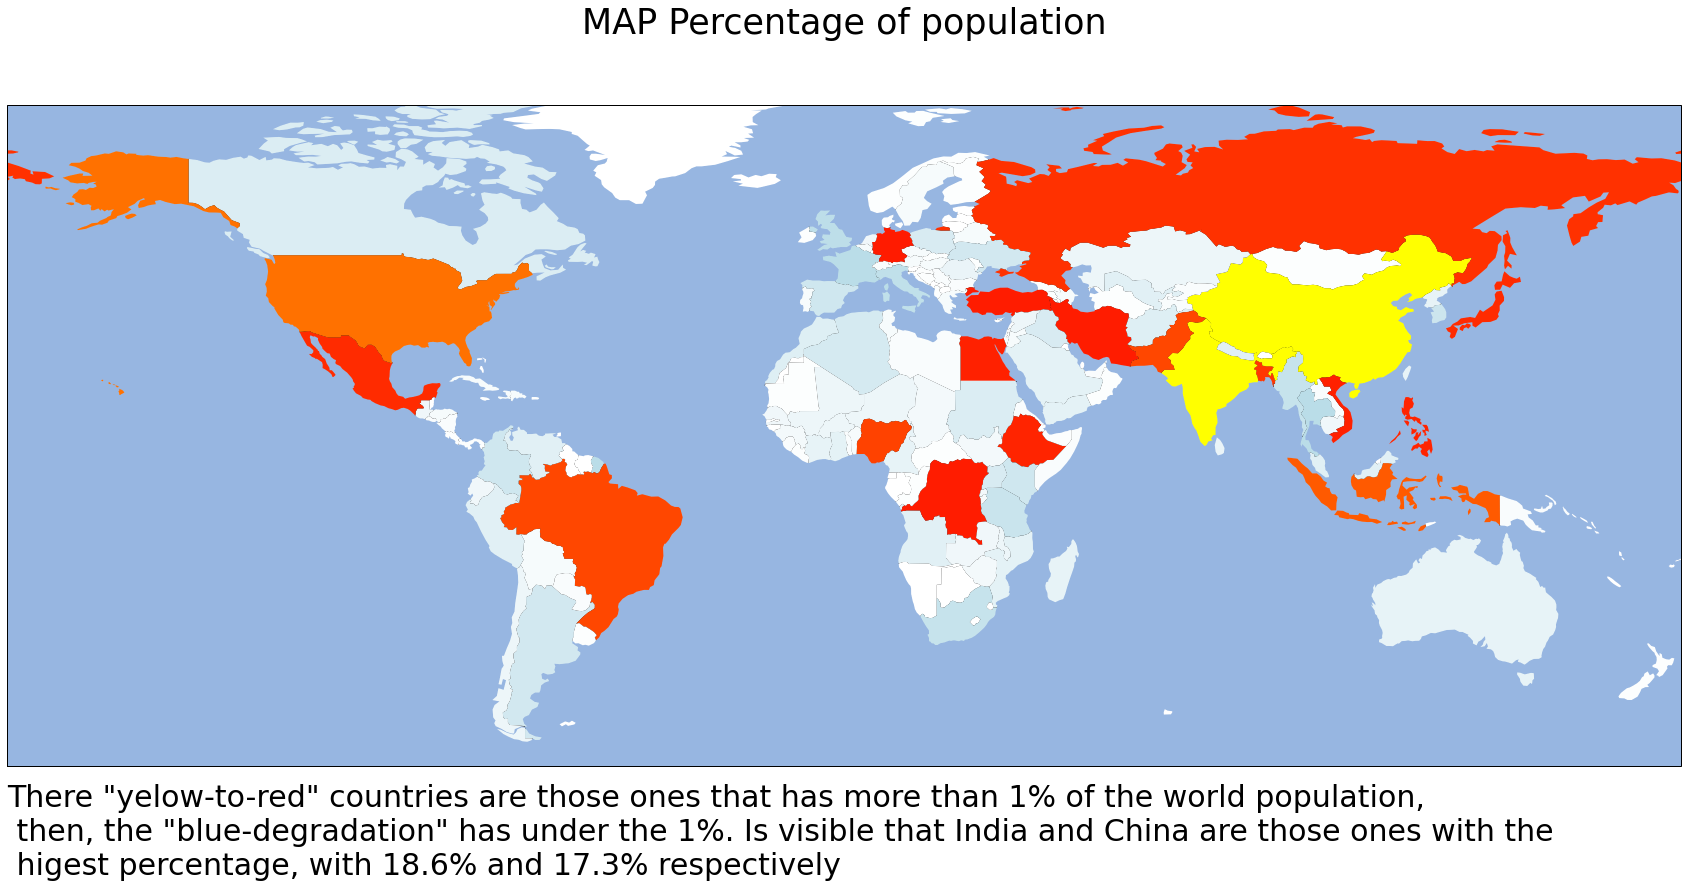

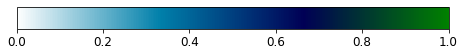

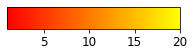

In [138]:
# IV.

# Map generator functions
geo = []
def dibujo_mapa_pays(pay, fc):
    if country.attributes['NAME_EN'] in pay:
        # Correction for the duplicate data of geometry.bounds : Republic of Congo, Guinea, Niger, Sudan
        if country.geometry.bounds in geo:
            pass
        else:
            geo.append(country.geometry.bounds)
            return ay.add_geometries([country.geometry], ccrs.PlateCarree(),
                                 facecolor=fc, label=country.attributes['NAME_EN'])


# Color generator        
def c_cm(s, c):
    cm = plt.cm.get_cmap(c)#'ocean_r', magma, autumn, winter
    return cm(s*10)


# # Map generator graphics
# ADD PERCENTAGE a las barras de leyenda!!!
fig = plt.subplots(figsize=(30,30))

ay = plt.axes(projection=ccrs.PlateCarree())
ay.add_feature(cartopy.feature.OCEAN)
ay.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=4)
ay.set_extent([-150, 60, -25, 60])
ay.set_title('MAP Percentage of population', size=35, ma = 'center', y = 1.1)
pa = []
pb = {}
for country in countries_pop:
    if country.attributes['POP_EST']/pop_total>0.01:
        c = 'autumn' #'magma'
    else:
        c = 'ocean_r'#, 'winter'
    pb[country.attributes['NAME_EN']]=c_cm(float(country.attributes['POP_EST'])/pop_total, c)
    pa.append(country.attributes['NAME_EN'])
    db = dibujo_mapa_pays(country.attributes['NAME_EN'], c_cm(float(country.attributes['POP_EST'])/pop_total, c))


'''
text_var : 'There "yelow-to-red" countries are those ones that has more than 1% of the world population,
then, the "blue-degradation" has under the 1%. Is visible that India and China are those ones with the 
higest percentage, with 18.6% and 17.3% respectively'
'''
text_var = 'There "yelow-to-red" countries are those ones that has more than 1% of the world population,\n then, the "blue-degradation" has under the 1%. Is visible that India and China are those ones with the \n higest percentage, with 18.6% and 17.3% respectively'

ay.text(0, -0.1, 
        s=text_var, 
        size=30, 
        va='center', 
        transform=ay.transAxes)


#  Legend bars ###
# BAR 1 #
fig = plt.figure(figsize=(30,3))
ax1 = fig.add_axes([0.5, .05, .2, 0.1]) 

cbar = colorbar.ColorbarBase(ax=ax1, 
                             cmap=plt.get_cmap('ocean_r'),#'autumn'),
                             orientation='horizontal')#,
                             #norm=colors.Normalize(vmin=0, vmax=1)) 
cbar.ax.tick_params(labelsize=12)
# vals1 = cbar.get_ticks()
# cbar.set_ticklabels(['{:.1f}%'.format(x) for x in vals1])


# BAR 2 ##
fig = plt.figure(figsize=(30,3))
ax2 = fig.add_axes([0.5, .05, .08, 0.1])

cbar = colorbar.ColorbarBase(ax=ax2, 
                             cmap=plt.get_cmap('autumn'),
                             orientation='horizontal',
                             norm=colors.Normalize(vmin=1, vmax=20),
                            )

# vals2 = cbar.get_ticks()
# st = ['{:.1f}%'.format(x) for x in vals2]
# cbar.ax.set_ticklabels(['{:.1f}%'.format(x) for x in vals2])

cbar.ax.tick_params(labelsize=12)


plt.show()



                    region_wb       pop_est
0                  Antarctica  4.050000e+03
1         East Asia & Pacific  2.285605e+09
2       Europe & Central Asia  9.146355e+08
3   Latin America & Caribbean  6.292756e+08
4  Middle East & North Africa  4.313808e+08
5               North America  3.622495e+08
6                  South Asia  1.731364e+09
7          Sub-Saharan Africa  1.027654e+09


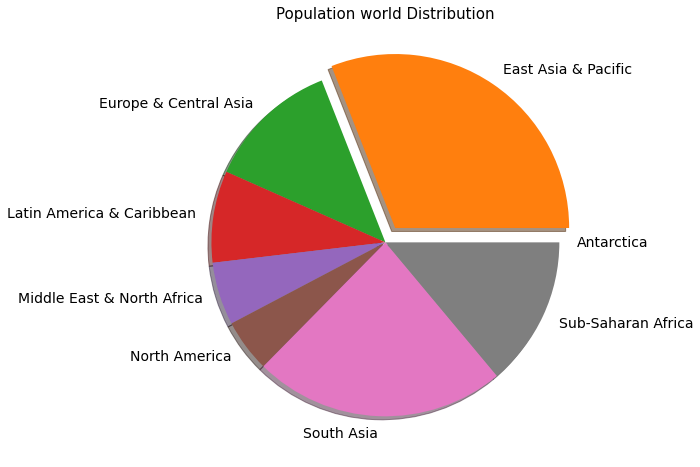

In [25]:
# V.

# Population distribution pie graph.
reg = shpfilename_df['region_wb'].unique()
ls = {}
for re in reg:
    ls[re] = shpfilename_df['pop_est'][shpfilename_df['region_wb']== re].sum()


ind = range(0,len(reg),1)
shpfilename_reg = pd.DataFrame(list(ls.items()),columns=['region_wb', 'pop_est'], index=ind)
explode = (0, 0.1, 0, 0, 0, 0, 0, 0)

print(shpfilename_reg)

ax1 = shpfilename_reg['pop_est'].plot(kind='pie',figsize=(8, 8), explode=explode, #autopct='%.2f%%',
                                    labels = reg, #[reg[7],reg[1],reg[5],reg[0],reg[4],reg[3],reg[6],reg[2]],
                                    shadow=True, textprops=({'fontsize': 14, 'color':'black'}))

ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_label('')
ax1.set_title("Population world Distribution", fontsize='15')

plt.show()



In [26]:
# VI.

## Add new data for square Km per country.

km = pd.read_csv('/home/hmdg/Documents/Data_Science/Maps/country_km.csv')

# Añado columna con la fuente de toda la info
km['general source'] = 'https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_superficie'

# Cambio nombre de columnas
lista_c = {km.columns[0] : 'ranked',
           'Territorio\n': 'name_es',
           'Superficie (km²)\n' : 'sup_Km2',
           'Datos\n' : 'datos',
           'general source': 'General_Source'
            }

km = km.rename(columns = lista_c)

# Hago copias de seguridad
kmc = km.copy()
shpfilename_dfc = shpfilename_df.copy()


# Resuelvo problema de longitud del nombre del país en el registro 138
kmc.loc[138] = 134,'Países Bajos','41 865','No incluye territorios.[31]',"https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_superficie"



In [27]:
# VII
# Combine the Population and Square Km (kmc & shpfilename_dfc) 

left = kmc
right = shpfilename_dfc

# Creo la tabla que une los datos de km2 con población de cada país / POR PAÍS
shp_km = pd.merge(left, right, on='name_es', how = 'inner', indicator=True)


#cambio el tipo de datos de la columna Km2 a numérico
s1 = shp_km.loc[:,'sup_Km2'].str.replace('\xc2\xa0','') #\s+ 

f = lambda x: "".join(x.split())
s1 = s1.apply(f)

shp_km['sup_Km2'] = pd.to_numeric(s1, errors='coerce', downcast = 'float')


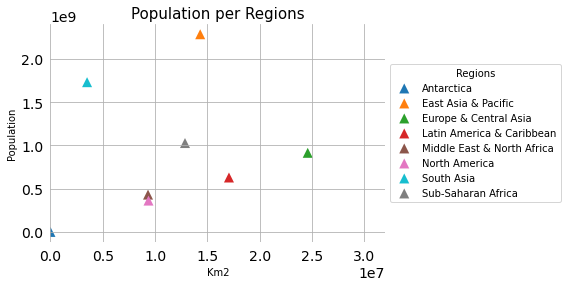

In [28]:
# IIX.

# Dibujo las correlaciones de las regiones con las poblaciones

#  creo la tabla resumen de km2 por región
rs = {}
for re in reg:
    rs[re] = shp_km['sup_Km2'][shp_km['region_wb']== re].sum()

ind = range(0,len(reg),1)
shpfilename_km = pd.DataFrame(list(rs.items()),columns=['region_wb', 'sup_Km2'], index=ind)

#Combino las dos tablas : la de los km con la de la población
left = shpfilename_km
right = shpfilename_reg

shp_km_pop = pd.merge(left, right, on='region_wb', how = 'inner', left_index = True, right_index=True)

# Para poner los colores que le corresponden

fig, ax = plt.subplots()

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:grey']

x = shp_km_pop['sup_Km2']
y = shp_km_pop['pop_est']
z = shp_km_pop['region_wb']
for s in range(len(x)):
    ax.scatter(x[s], y[s], c=colors[s], label=z[s], #s=scale,
               alpha=1,s=100, marker='^', edgecolors='none')

ax.legend(title="Regions",
          loc="center left",
          bbox_to_anchor=(0, 0, 0.5, 1))
ax.set_title('Population per Regions', fontsize=15)
ax.set_xlabel('Km2', fontsize=10)
ax.set_ylabel('Population', fontsize=10)
ax.set_xlim(0.0, 3.2e7)

### Dispersión de los datos

plt.show()

#### HACER ESTE GRÁFICO DISGREGADO POR PAÍS  ####

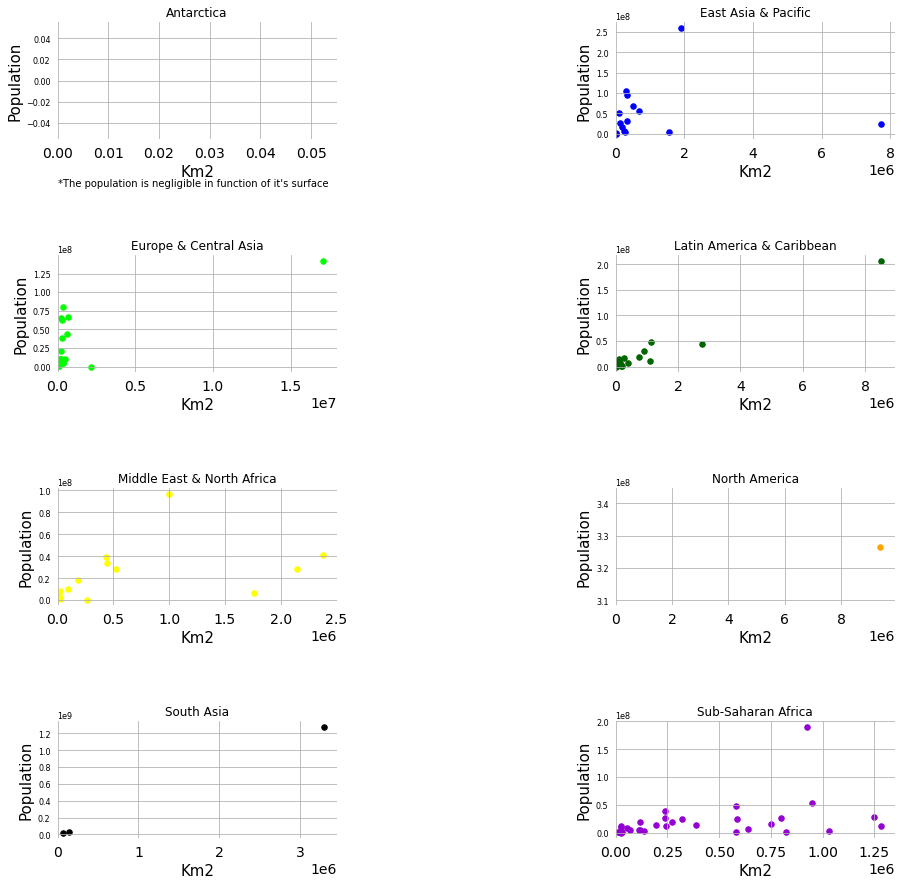

In [53]:
# IIX.

# rg = shpfilename_df['region_wb'].unique()
# rg = rg[1:]

fig, ax = plt.subplots(4, 2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=1)

plt.rcParams['ytick.labelsize']=8
plt.rcParams['xtick.labelsize']=10

ax = ax.ravel() # para convertir el arreglo en una matriz plana, una lista

colores = np.array(['red', 'blue', 'lime', 'darkgreen', 'yellow', 'orange', 'black', 'darkviolet'])

for l in range(len(reg)):
    ax[l].scatter(x = shp_km[shp_km['region_wb']==reg[l]]['sup_Km2'], 
                  y = shp_km[shp_km['region_wb']==reg[l]]['pop_est'],
                  s = 30, marker='o', color = colores[l]) 
    
    ax[l].set_title(reg[l], fontsize='large')
    ax[l].set_ylabel('Population',fontsize=15)
    ax[l].set_xlabel('Km2', fontsize=15)
    ax[l].set_xlim(0)
    if l==0:
        ax[l].text(0,-0.1,"*The population is negligible in function of it's surface")

plt.rcParams['xtick.labelsize']=14

plt.show()
